In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/memotion_dataset_7k/train.csv')
val_dataset = pd.read_csv('/content/drive/MyDrive/memotion_dataset_7k/val.csv')

In [ ]:
train_dataset['overall_sentiment'].value_counts()

,count
overall_sentiment,
positive,2501
neutral,1761
very_positive,826
negative,384
very_negative,121


In [ ]:
train_dataset['overall_sentiment'] = train_dataset['overall_sentiment'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

<ipython-input-4-7787e5163934>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dataset['overall_sentiment'] = train_dataset['overall_sentiment'].replace({


In [ ]:
train_dataset['overall_sentiment'].value_counts()

,count
overall_sentiment,
2,3327
1,1761
0,505


In [ ]:
val_dataset['overall_sentiment'] = val_dataset['overall_sentiment'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

<ipython-input-6-f0dc68a93275>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_dataset['overall_sentiment'] = val_dataset['overall_sentiment'].replace({


In [ ]:
val_dataset['overall_sentiment'].value_counts()

,count
overall_sentiment,
2,833
1,440
0,126


In [ ]:
!pip install text_hammer

In [ ]:
import text_hammer as th

In [ ]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 1.07 ms, sys: 0 ns, total: 1.07 ms
Wall time: 2.51 ms


In [ ]:
train_dataset = text_preprocessing(train_dataset, 'text_ocr')
val_dataset = text_preprocessing(val_dataset, 'text_ocr')

  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/5593 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

In [ ]:
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Create a blank image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a string
        if not isinstance(caption, str):
            caption = str(caption)

        if isinstance(caption, list):
            caption = ' '.join(caption)

        if not caption:
            caption = "empty caption"

        # Encode caption
        encoded_caption = self.tokenizer([caption], return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment)

        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask, 'sentiment': sentiment_class}

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# Custom Channel Attention module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute average and maximum across spatial dimensions separately
        avg_out = torch.mean(x, dim=(2, 3), keepdim=True)
        max_out = torch.max(x, dim=2, keepdim=True)[0]
        max_out = torch.max(max_out, dim=3, keepdim=True)[0]

        avg_out = self.fc2(self.relu(self.fc1(avg_out)))
        max_out = self.fc2(self.relu(self.fc1(max_out)))
        return self.sigmoid(avg_out + max_out)


class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionPooling, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, hidden_states):
        # hidden_states shape: (batch_size, sequence_length, hidden_size)
        attention_scores = self.attention(hidden_states)  # (batch_size, sequence_length, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
        weighted_sum = torch.sum(attention_weights * hidden_states, dim=1)  # (batch_size, hidden_size)
        return weighted_sum


# Define custom model with CLIP and dense layers
class CustomCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super(CustomCLIPModel, self).__init__()
        self.clip_model = clip_model

        self.num_channels = 512  # Example: Replace with the actual number of channels from clip_model
        self.hidden_size = 512   # Replace with the actual hidden size from the CLIP model's text encoder

        # Attention Pooling for text features
        self.text_attention_pooling = AttentionPooling(hidden_size=self.hidden_size)

        # Attention modules for image features
        self.spatial_attention = SpatialAttention()
        self.channel_attention = ChannelAttention(in_planes=self.num_channels)

        # self.fc1 = nn.Linear(self.num_channels + self.hidden_size, 512)
        self.fc1 = nn.Linear(self.num_channels + self.hidden_size, self.num_channels + self.hidden_size)
        self.dropout1 = nn.Dropout(0.5)
        # self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(self.num_channels + self.hidden_size, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 3)
        self.gelu = nn.GELU()

    def forward(self, image, input_ids, attention_mask):
        # Extract text and image features using the CLIP model
        text_features = self.clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip_model.get_image_features(pixel_values=image)

        # Ensure image_features have the correct shape (batch_size, num_channels, height, width)
        if len(image_features.shape) == 2:
            image_features = image_features.unsqueeze(-1).unsqueeze(-1)

        # Apply spatial and channel attention to image features
        spatial_att = self.spatial_attention(image_features)
        channel_att = self.channel_attention(image_features)

        image_features = image_features * spatial_att * channel_att

        # Flatten the image features or perform adaptive pooling
        image_features = torch.nn.functional.adaptive_avg_pool2d(image_features, (1, 1)).squeeze(-1).squeeze(-1)

        # Apply attention-based pooling to the text features
        text_features = self.text_attention_pooling(text_features.unsqueeze(1))

        image_features = torch.nn.functional.normalize(image_features, dim=1)
        text_features = torch.nn.functional.normalize(text_features, dim=1)

        combined_features = torch.cat((text_features, image_features), dim=1)

        x = self.fc1(combined_features)
        # x = self.bn1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.dropout3(x)
        logits = self.fc4(x)

        return logits, image_features, text_features

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.cross_entropy_loss(logits, labels)
        return ce_loss


def train_epoch(model, train_loader, optimizer, device, criterion):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()
        logits, image_features, text_features = model(images, input_ids, attention_mask)
        loss = criterion(logits, sentiments)
        loss.backward()
        optimizer.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    accuracy = correct_predictions / total_predictions
    return loss_meter, accuracy


def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_features, text_features = model(images, input_ids, attention_mask)
            loss = criterion(logits, sentiments)

            loss_meter.update(loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            true = sentiments.cpu().numpy()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(true)

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, accuracy

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(p=0.2),  # Added augmentation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model = CustomCLIPModel(clip_model)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


train_image_dir = '/content/drive/MyDrive/memotion_dataset_7k/training_images'
val_image_dir = '/content/drive/MyDrive/memotion_dataset_7k/validation_images'

train_dataset = MemeDataset(
    images=train_dataset['image_name'].tolist(),
    captions=train_dataset['text_ocr'].tolist(),
    sentiments=train_dataset['overall_sentiment'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_dataset['image_name'].tolist(),
    captions=val_dataset['text_ocr'].tolist(),
    sentiments=val_dataset['overall_sentiment'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
print(model)

CustomCLIPModel(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, b

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
num_epochs = 10


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

# Loss functions
criterion = CustomLoss()

BEST_MODEL_PATH = 'best_model.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)
    val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss.avg}, Train Accuracy: {train_accuracy}")
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    scheduler.step()

model.load_state_dict(torch.load(BEST_MODEL_PATH))

Epoch 1/10


100%|██████████| 175/175 [11:45<00:00,  4.03s/it, lr=1e-5, train_loss=1.13]


Train Loss: 1.1322011716801046, Train Accuracy: 0.37600572143751115
Val Loss: 1.0851053292620088, Val Accuracy: 0.3817012151536812
Epoch 2/10


100%|██████████| 175/175 [01:54<00:00,  1.52it/s, lr=9.99e-6, train_loss=1.09]


Train Loss: 1.086926548484824, Train Accuracy: 0.41355265510459505
Val Loss: 1.081637760244837, Val Accuracy: 0.35954253037884204
Epoch 3/10


100%|██████████| 175/175 [01:54<00:00,  1.53it/s, lr=9.99e-6, train_loss=1.06]


Train Loss: 1.060844638192886, Train Accuracy: 0.43876273913820846
Val Loss: 1.0718666401141197, Val Accuracy: 0.4131522516082916
Epoch 4/10


100%|██████████| 175/175 [01:58<00:00,  1.48it/s, lr=9.98e-6, train_loss=1.02]


Train Loss: 1.0227888843976127, Train Accuracy: 0.4845342392276059
Val Loss: 1.070766702560632, Val Accuracy: 0.43173695496783415
Epoch 5/10


100%|██████████| 175/175 [01:56<00:00,  1.50it/s, lr=9.98e-6, train_loss=0.971]


Train Loss: 0.9709634517016276, Train Accuracy: 0.5347756123726086
Val Loss: 1.1019743445773393, Val Accuracy: 0.43173695496783415
Epoch 6/10


100%|██████████| 175/175 [01:58<00:00,  1.48it/s, lr=9.97e-6, train_loss=0.885]


Train Loss: 0.8854466389399105, Train Accuracy: 0.6111210441623458
Val Loss: 1.1357201126492646, Val Accuracy: 0.4639027877055039
Epoch 7/10


100%|██████████| 175/175 [01:56<00:00,  1.50it/s, lr=9.97e-6, train_loss=0.688]


Train Loss: 0.6875870459497071, Train Accuracy: 0.7529054174861434
Val Loss: 1.0652482452948149, Val Accuracy: 0.5568263045032166
Epoch 8/10


100%|██████████| 175/175 [01:55<00:00,  1.52it/s, lr=9.96e-6, train_loss=0.52]


Train Loss: 0.5195939454008424, Train Accuracy: 0.835687466475952
Val Loss: 1.269041540027943, Val Accuracy: 0.4781987133666905
Epoch 9/10


100%|██████████| 175/175 [01:56<00:00,  1.50it/s, lr=9.95e-6, train_loss=0.397]


Train Loss: 0.3966618752662854, Train Accuracy: 0.875022349365278
Val Loss: 1.2222368886762214, Val Accuracy: 0.538241601143674
Epoch 10/10


100%|██████████| 175/175 [01:55<00:00,  1.51it/s, lr=9.95e-6, train_loss=0.315]


Train Loss: 0.31489926540380553, Train Accuracy: 0.9156087967101735
Val Loss: 1.312463773583582, Val Accuracy: 0.5654038598999285


<ipython-input-14-a3ceb85e4756>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, classification_report

val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader,  'cuda' if torch.cuda.is_available() else 'cpu', criterion)

f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')
f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
class_report = classification_report(val_true_labels, val_predictions)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print(f'F1 Weighted: {f1_weighted:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Classification Report:\n{class_report}')

Best Validation Accuracy: 0.5654038598999285
F1 Weighted: 0.4669
F1 Macro: 0.2862
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.02      0.02       126
           1       0.37      0.07      0.11       440
           2       0.59      0.91      0.72       833

    accuracy                           0.57      1399
   macro avg       0.34      0.33      0.29      1399
weighted avg       0.47      0.57      0.47      1399



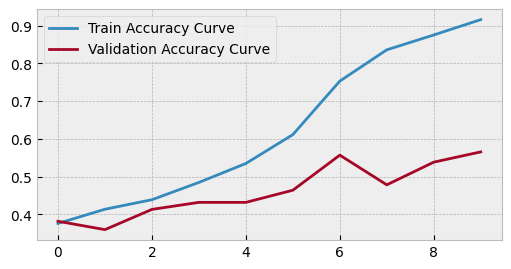

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(6,3))
plt.plot(train_accuracies, label='Train Accuracy Curve')
plt.plot(val_accuracies, label='Validation Accuracy Curve')
plt.legend()
plt.show()

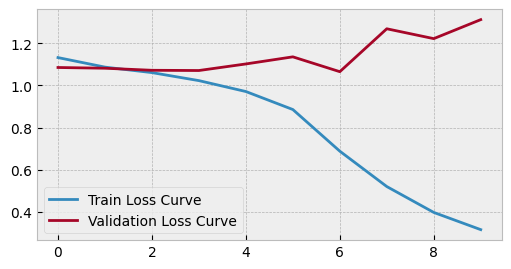

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(train_losses, label='Train Loss Curve')
plt.plot(val_losses, label='Validation Loss Curve')
plt.legend()
plt.show()